# 時系列データのクラスタリング(ward法)
---
- 施策を打つ際、その効果を高めるためにユーザーをセグメントに分けることがよくある
- セグメントの分け方は様々だが、ここでは時系列データの推移パターンによってクラスタリングすることでセグメント分けをしてみる
- 時系列データとしてアプリの使用時間や滞在時間の変化に注目すれば、ユーザーのアプリへの興味や熱意の変化を捉えられると考えられる

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

## 前処理
---
元のファイルでは数字ごとの区切りに";"、小数点に","が用いられているために、これらをそれぞれ","と"."に置換する

In [2]:
# ファイルをパースして区切り文字を置換
with open('../input/LD2011_2014.txt', 'r') as f:
    file = f.read()

file = file.replace(',', '.')
file = file.replace(';', ',')

with open('../input/LD2011_2014_parsed.txt', 'w') as f:
    f.write(file)

区切り文字の置換後に再度ファイルを読み込み

In [3]:
nrows = None
df = pd.read_csv('../input/LD2011_2014_parsed.txt', nrows=nrows)
df.head(5)

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,...,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.760886,0.0,1003.780488,247.095070,177.559913,147.543641,264.115756,644.444444,135.514706,45.08125,129.629630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.760886,0.0,967.195122,243.573944,177.559913,131.321696,264.115756,592.592593,129.632353,50.08750,119.212963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.996944,0.0,991.585366,231.232394,180.827887,136.321696,283.440514,622.222222,125.205882,41.95625,127.314815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.288770,0.0,991.585366,232.992958,181.917211,130.074813,293.086817,614.814815,125.205882,45.08125,125.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.760886,0.0,967.195122,234.753521,177.559913,125.087282,276.977492,607.407407,141.397059,45.08125,122.685185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 型をfloatに統一
for col in df.drop('Unnamed: 0', axis=1).columns:
    df[col] = df[col].astype(float)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,...,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
854,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,0.001134,1.000000e-10,0.018845,0.003693,0.002948,0.002616,0.005677,0.012896,0.001785,0.000973,0.002432,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10
257,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,...,0.000412,1.000000e-10,0.005461,0.001197,0.000865,0.000848,0.001535,0.003982,0.000765,0.000260,0.001266,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10
759,7.752202e-06,1.303429e-04,1.592199e-05,4.097323e-04,2.532890e-04,8.363150e-04,1.726607e-05,1.254656e-03,2.776698e-04,2.233301e-04,1.957344e-04,1.000000e-10,2.330032e-04,1.793247e-04,1.000000e-10,1.913328e-04,2.140527e-04,8.001858e-04,3.683660e-05,1.883751e-04,7.675898e-04,1.255220e-04,4.432460e-05,1.256941e-04,1.113274e-03,8.800721e-05,8.928724e-05,3.821634e-04,1.683058e-04,1.000000e-10,4.018905e-04,1.000000e-10,1.682707e-04,9.811517e-05,4.983216e-04,1.051417e-04,5.080766e-04,5.037308e-04,1.000000e-10,6.545074e-04,1.000000e-10,2.018134e-04,3.887377e-03,1.338310e-04,1.653803e-04,5.500757e-04,1.197157e-04,7.352220e-05,3.851159e-03,6.956567e-04,...,0.000426,1.000000e-10,0.006206,0.001283,0.001391,0.000909,0.001810,0.004072,0.000828,0.000302,0.00067

(1000, 370)


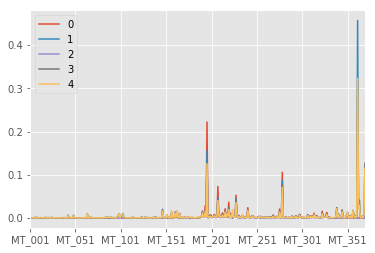

In [5]:
n_sample = 1000
np.random.seed(123)
df_use = df.drop('Unnamed: 0', axis=1).sample(n=n_sample).reset_index(drop=True)

# サンプル同士で値に違いがない(=すべてゼロ)カラムは削除
for col in df_use.columns:
    if df_use[col].nunique() == 1:
        df_use = df_use.drop(col, axis=1)

# 正規化
max_val = df_use.max().max()
df_use = df_use / max_val

# ゼロ割り回避
df_use = df_use.replace(0, 1e-10)

display(df_use.sample(n=5))
print(df_use.shape)
df_use.head(5).T.plot(); plt.show()

時系列データのいくつかをサンプリングして図化したグラフから、推移が立ち上がるタイミングはほぼ同じ、ただし立ち上がりの度合いが異なるようなデータと言える

## 階層クラスタリング実行
---
- 時系列データの距離を見積もる方法はいくつかあるが<sup>(1)</sup>、ここでは変化のパターンがどれだけ違うかを示す相関距離を用いる
- scikit-learnやscipyのkmeansではユークリッド距離のみしか使えないため、相関距離(のみならず様々な距離関数)を使えるscipyの階層型クラスタリングを使う
- 本来、ward法ではユークリッド距離しか使えないが、立式上、相関距離を使っても問題はなさそうなので相関距離を使う
- 上記グラフで立ち上がるタイミングがほぼ同じため、ユークリッド距離でも同じように求められそうではある

(1) https://arxiv.org/pdf/1710.02268.pdf

Number of cluster: 3
Number of elements in cluster 0: 229
Number of elements in cluster 1: 172
Number of elements in cluster 2: 599


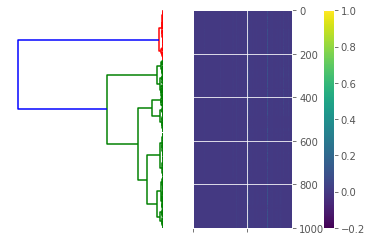

In [6]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

x_train = df_use.copy()

# 階層クラスタリングの設定
metric = 'correlation'    # 'correlation', 'euclidean', 'cosine'
method = 'ward'

# 階層クラスタリングを実行, デンドログラムを表示
plt.subplot(1, 2, 1)

link = linkage(pdist(x_train, metric=metric), method=method, metric=metric)
dendro = dendrogram(
    link, 
    orientation='left', 
    no_labels=True, 
    distance_sort='descending')
plt.gca().set_axis_off()


n_cluster = 3         #  クラスター数はデンドログラムを見て調整
cluster_idx = fcluster(link, n_cluster, criterion='maxclust')
cluster_idx_max = np.max(cluster_idx)
print('Number of cluster:', cluster_idx_max)
for i in range(cluster_idx_max):
     print('Number of elements in cluster {}: {}' .format(i, len(np.where(cluster_idx==i+1)[0])))

# プレイ時間のヒートマップをクラスタリング結果の順番に表示
plt.subplot(1, 2, 2)

x_train_leaf = x_train.iloc[[x_train.index[i] for i in dendro['leaves']]]    # クラスタリング結果に並べ替え

plt.imshow(x_train_leaf, aspect='auto', interpolation='none', vmin=-0.2, vmax=1.0)
plt.colorbar(pad=0.2)
plt.gca().yaxis.tick_right()
plt.tick_params(labelbottom='off')
plt.show()

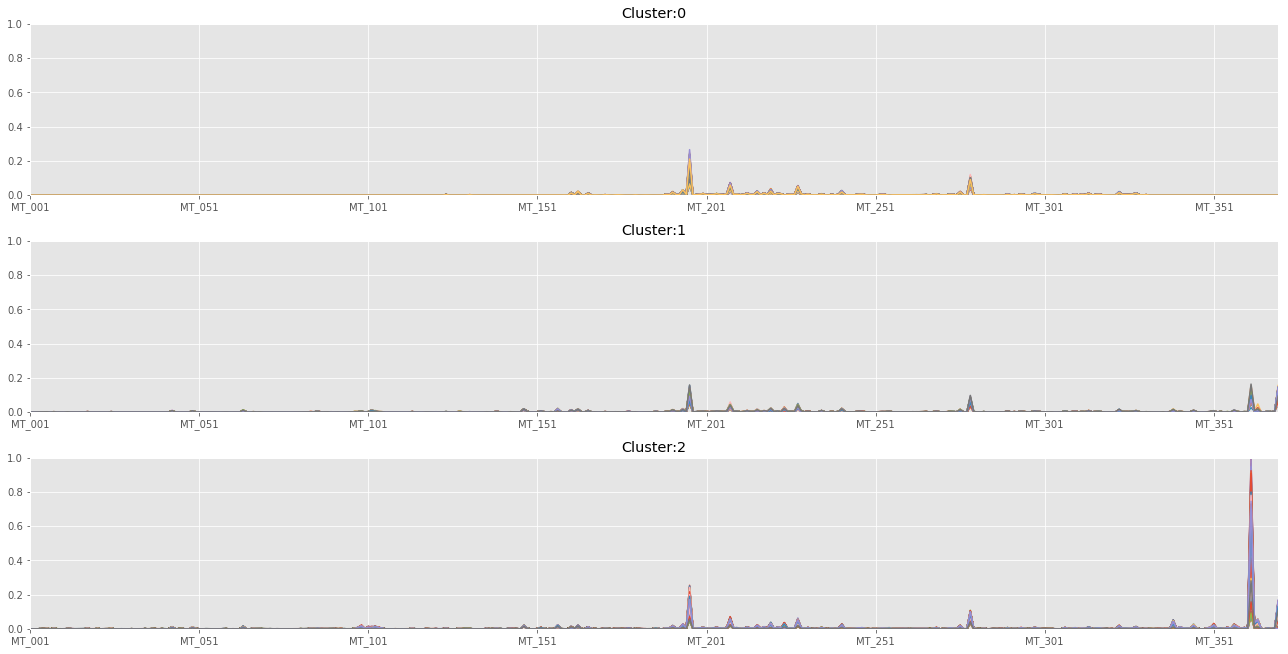

In [7]:
# クラスターごとに時系列データを表示
for idx in range(cluster_idx_max):
    plt.subplot(8, 1, idx+1)
    for i in range(len(df_use.index)):
        if cluster_idx[i]==idx+1:
            df_use.iloc[i, :].plot(figsize = (18, 24))
            plt.ylim(0, 1)
            #plt.xlim(20, 40)
            plt.title('Cluster:{}'.format(idx))
            plt.tight_layout()
plt.show()

大きく跳ねている箇所が3つあるが、3つ目の跳ね方に違いが出ている → それぞれを拡大

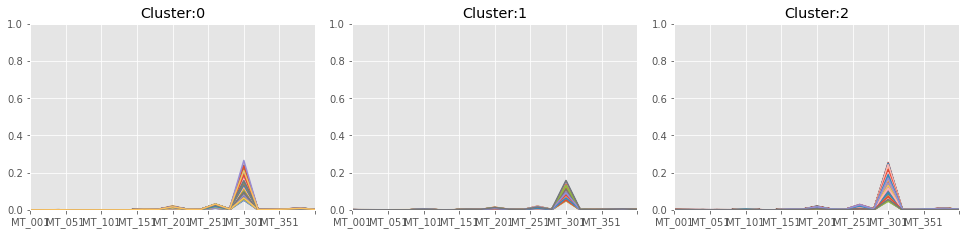

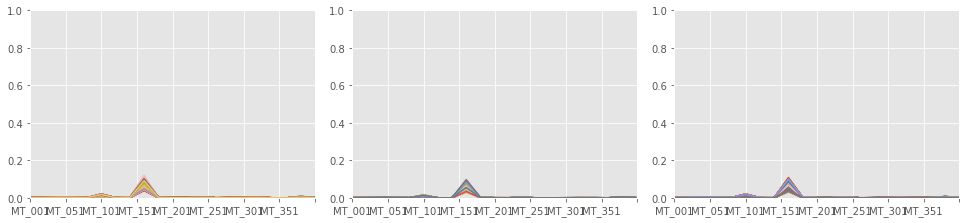

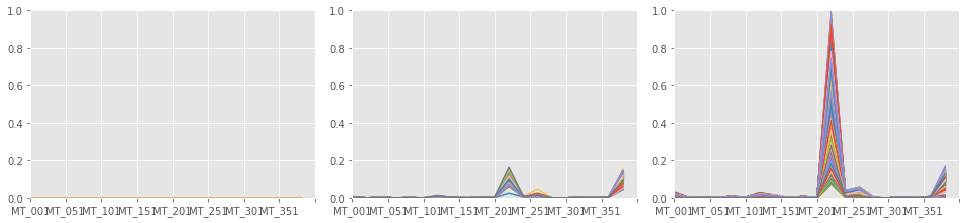

In [8]:
# 1つ目
for idx in range(cluster_idx_max):
    plt.subplot(8, 4, idx+1)
    for i in range(len(df_use.index)):
        if cluster_idx[i]==idx+1:
            df_use.iloc[i, :].plot(figsize = (18, 24))
            plt.ylim(0, 1)
            plt.xlim(180, 200)
            plt.title('Cluster:{}'.format(idx))
            plt.tight_layout()
plt.show()

# 2つ目
for idx in range(cluster_idx_max):
    plt.subplot(8, 4, idx+1)
    for i in range(len(df_use.index)):
        if cluster_idx[i]==idx+1:
            df_use.iloc[i, :].plot(figsize = (18, 24))
            plt.ylim(0, 1)
            plt.xlim(270, 290)
            plt.tight_layout()
plt.show()
            
# 3つ目
for idx in range(cluster_idx_max):
    plt.subplot(8, 4, idx+1)
    for i in range(len(df_use.index)):
        if cluster_idx[i]==idx+1:
            df_use.iloc[i, :].plot(figsize = (18, 24))
            plt.ylim(0, 1)
            plt.xlim(350, 370)
            plt.tight_layout()
plt.show()

各クラスターの特徴
- cluster:0 3つ目は増加が見られない
- cluster:1 3つ目の増加が確認できるものの小さい、時系列最後の増加がある
- cluster:2 3つ目の増加が大きい、時系列最後の増加がある